In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression, SGDClassifier
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report,make_scorer, roc_curve 
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
import string
from sklearn.pipeline import Pipeline
import scikitplot  #to make things easy
import run_model_metrics
import mglearn
from imblearn.over_sampling import SMOTE, RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer  
from nltk.tokenize import TweetTokenizer 
#import mglearn as mg

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df.csv')

In [3]:
from sklearn.model_selection import train_test_split
# 30% test, 70% train split
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_text, df.edInput, test_size = 0.3, random_state=10, shuffle=True, stratify = df[['edInput']])

print (X_train.shape, X_test.shape)

(21016,) (9008,)


# Bag of Words

In [43]:
# fit CountVectorizer

vect = CountVectorizer().fit(X_train)
# transform 
x_train = vect.transform(X_train)
print("X_train:\n{}".format(repr(X_train)))

x_test = vect.transform(X_test)
print("X_test:\n{}".format(repr(X_test)))

print("Vocabulary length: ", len(vect.vocabulary_))
#print("Vocabulary length: \n", vect.vocabulary_)

X_train:
22147    a japanese company is embroiled in controversy...
13685    heres how to address your partners annoying ha...
3331     at least  advertisers have stopped advertising...
26373                          these dinosaurs are cuddly 
28213    daniel  dubois has his anthony joshua moment a...
                               ...                        
5129     foods taste blander when flying which makes th...
27307         this chicken parm pizza is topped with eggs 
23423                            the race costs  to enter 
18275    the supreme court has put on hold lower court ...
10358    a weapon tested by north korea is thought to h...
Name: cleaned_text, Length: 21016, dtype: object
X_test:
17677     one small leg of this ham can cost upwards of   
22660    this is the startup that finally made me jaded...
22083    the year was   hooters had an airline and thin...
21075    this game from the creator of rick and morty i...
13247    this student group is turning lobster sh

In [5]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 22562
First 20 features:
['__maxwell', '_a_garcia', '_ac_payne', '_albertdeitch', '_athey', '_battilana', '_bighit', '_c_', '_cap', '_chat', '_chris', '_com', '_crook', '_ct', '_cyran', '_davids', '_de_reya', '_donaldson', '_dyer', '_emif']
Features 20010 to 20030:
['ternate', 'terrain', 'terrible', 'terribly', 'terrific', 'terrified', 'terrifying', 'terrifyingamazing', 'territories', 'territory', 'terror', 'terrorism', 'terrorismfinancing', 'terrorismrelated', 'terrorist', 'terrorists', 'terry', 'tesla', 'teslas', 'teslonda']
Every 2000th feature:
['__maxwell', 'between', 'commits', 'doubt', 'fresh', 'indefinitely', 'malaysia', 'openly', 'rainy', 'sheldon', 'term', 'wheat']


Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

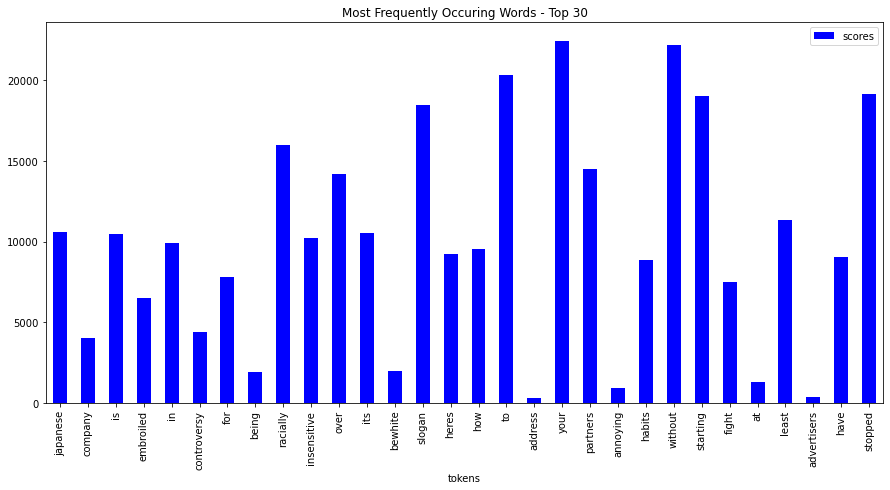

In [8]:
df_tokenscores = (pd
                  .DataFrame(vect.vocabulary_.items(), columns =['tokens','scores'])
                  #.sort_values(by=['scores'], ascending=False)
                 )
df_tokenscores.head(30).plot(x='tokens', y='scores', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")
#df_tokenscores.sort_values(by=['scores'],ascending=False).head(5000)

# Model Development and Evaluation

In [9]:
# Logistic Regression with Grid search CV
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), param_grid, cv=5)
grid.fit(x_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.80
Best parameters:  {'C': 1}


In [10]:
# Logistic Regression with cross validation
lr = LogisticRegression( class_weight='balanced', max_iter=1000, C=1)
lr.fit(x_train, y_train)

scores = cross_val_score(lr, x_train, y_train, cv=5) 
#print("Scores: {:.2f}".format(scores))
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.80


In [11]:
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

0.8071714031971581

Confusion Matrix :
[[2892  765]
 [ 972 4379]]
Accuracy Score : 0.8071714031971581
Report : 
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      3657
           1       0.85      0.82      0.83      5351

    accuracy                           0.81      9008
   macro avg       0.80      0.80      0.80      9008
weighted avg       0.81      0.81      0.81      9008

F-Measure: 0.834

Metrics for Test Data:
precision:0.85
recall:  0.82 
f1 score: 0.83 


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

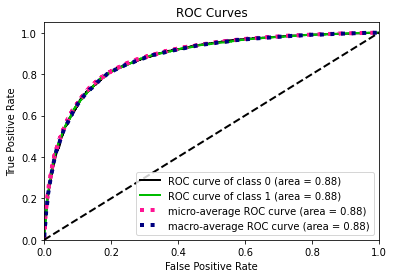

In [12]:
#prediction the results for test data
lr.fit(x_train, y_train)
preds = lr.predict(x_test)
actual = y_test
predicted = preds
results = confusion_matrix(actual, predicted) 
print('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(actual, predicted)) 
print ('Report : ')
print (classification_report(actual, predicted) )
score_2 = f1_score(actual, predicted, average = 'binary')
print('F-Measure: %.3f' % score_2)
#printing all the metrics for test data
print("\nMetrics for Test Data:") 


print("precision:{:.2f}".format(precision_score(y_test, preds)))
print("recall:  {:.2f} ".format(recall_score(y_test, preds)))
print("f1 score: {:.2f} ".format(f1_score(y_test, preds)))


import scikitplot as skplt #to make things easy
preds_proba = lr.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test, preds_proba)

<AxesSubplot:>

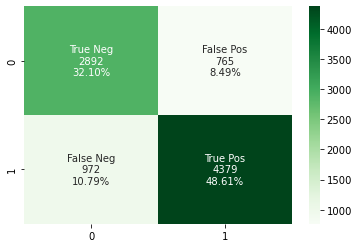

In [13]:
#heatmap for confusion matrix

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                results.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     results.flatten()/np.sum(results)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(results, annot=labels, fmt='', cmap='Greens')

# using pipeline


Metrics for Train Data:
Cross-validation score:  0.9398077655119909
Confusion matrix: 
 [[ 8088   443]
 [  822 11663]]
precision:0.96
recall:  0.93 
f1 score: 0.95 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      8531
           1       0.96      0.93      0.95     12485

    accuracy                           0.94     21016
   macro avg       0.94      0.94      0.94     21016
weighted avg       0.94      0.94      0.94     21016


Metrics for Test Data:
Cross-validation score:  0.8075044404973357
Confusion matrix: 
 [[2894  763]
 [ 971 4380]]
precision:0.85
recall:  0.82 
f1 score: 0.83 
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      3657
           1       0.85      0.82      0.83      5351

    accuracy                           0.81      9008
   macro avg       0.80      0.80      0.80      9008
weighted avg       0.81      0.81      0.81      9008



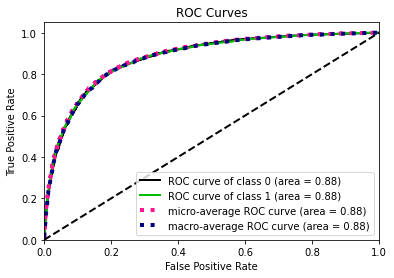

In [14]:
model_name='base_model'
vect = CountVectorizer()
lr = LogisticRegression(class_weight='balanced')
pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', lr)])
metrics_dict, pred_train, pred_test, preds_f_metrics = run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)

df_metrics = pd.DataFrame([metrics_dict])

# Model Trial

In [15]:
#max_df tries for different models
def train_and_eval_model(min_df):
    vect = CountVectorizer(min_df = min_df)
    lr = LogisticRegression(class_weight='balanced')
    pipeline = Pipeline(steps=[('vectorizer', vect),
                                ('classifier', lr)])
    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    model_name='model_1_tries'
    metrics_dict, pred_train, pred_test, preds_proba = run_model_metrics.run_pipeline(model_name, pipeline, 
                                                                                      X_train, y_train, 
                                                                                      X_test, y_test)
    
    
    test_precision_score = precision_score(y_test, pred_test)
    test_recall_score = recall_score(y_test, pred_test)
    test_f1_score = f1_score(y_test, pred_test)
    test_results = np.append(np.array([min_df, test_precision_score,test_recall_score]),
                                      test_f1_score
                                     )
    return test_results

MINIMUM DOCUMENT FREQUENCY = 2


Metrics for Train Data:
Cross-validation score:  0.923486867148839
Confusion matrix: 
 [[ 7983   548]
 [ 1060 11425]]
precision:0.95
recall:  0.92 
f1 score: 0.93 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      8531
           1       0.95      0.92      0.93     12485

    accuracy                           0.92     21016
   macro avg       0.92      0.93      0.92     21016
weighted avg       0.93      0.92      0.92     21016


Metrics for Test Data:
Cross-validation score:  0.8057282415630551
Confusion matrix: 
 [[2884  773]
 [ 977 4374]]
precision:0.85
recall:  0.82 
f1 score: 0.83 
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      3657
           1       0.85      0.82      0.83      5351

    accuracy                           0.81      9008
   macro avg       0.80      0.80      0.80      9008
weighted avg       0.81      0.81      0.81


Metrics for Train Data:
Cross-validation score:  0.8590121811952798
Confusion matrix: 
 [[ 7488  1043]
 [ 1920 10565]]
precision:0.91
recall:  0.85 
f1 score: 0.88 
              precision    recall  f1-score   support

           0       0.80      0.88      0.83      8531
           1       0.91      0.85      0.88     12485

    accuracy                           0.86     21016
   macro avg       0.85      0.86      0.86     21016
weighted avg       0.86      0.86      0.86     21016


Metrics for Test Data:
Cross-validation score:  0.7908525754884547
Confusion matrix: 
 [[2871  786]
 [1098 4253]]
precision:0.84
recall:  0.79 
f1 score: 0.82 
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      3657
           1       0.84      0.79      0.82      5351

    accuracy                           0.79      9008
   macro avg       0.78      0.79      0.79      9008
weighted avg       0.80      0.79      0.79      9008

MINIMUM DOCUMENT FR


Metrics for Train Data:
Cross-validation score:  0.8284640274076894
Confusion matrix: 
 [[ 7302  1229]
 [ 2376 10109]]
precision:0.89
recall:  0.81 
f1 score: 0.85 
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      8531
           1       0.89      0.81      0.85     12485

    accuracy                           0.83     21016
   macro avg       0.82      0.83      0.83     21016
weighted avg       0.84      0.83      0.83     21016


Metrics for Test Data:
Cross-validation score:  0.7814165186500888
Confusion matrix: 
 [[2883  774]
 [1195 4156]]
precision:0.84
recall:  0.78 
f1 score: 0.81 
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3657
           1       0.84      0.78      0.81      5351

    accuracy                           0.78      9008
   macro avg       0.77      0.78      0.78      9008
weighted avg       0.79      0.78      0.78      9008



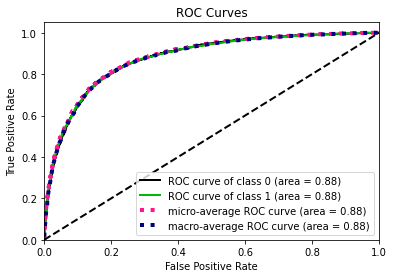

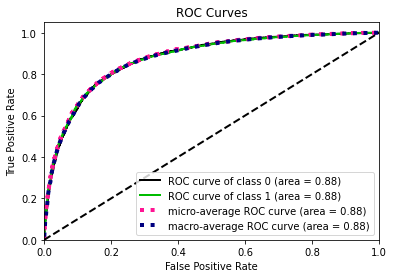

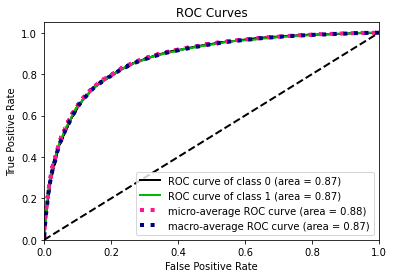

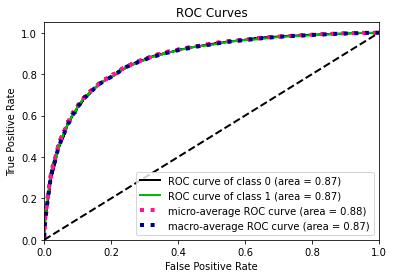

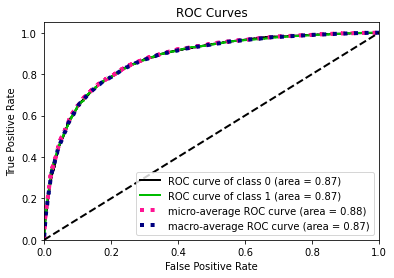

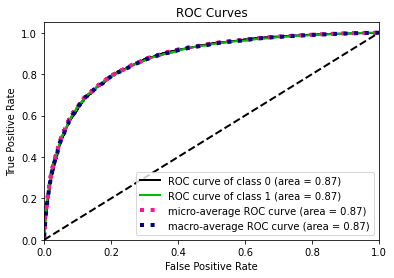

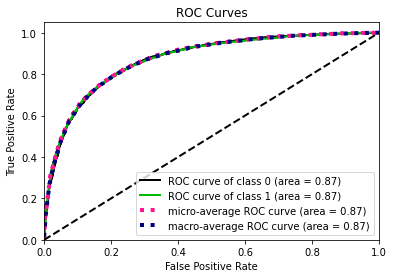

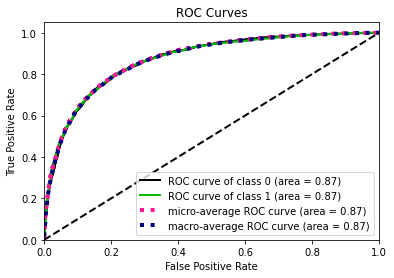

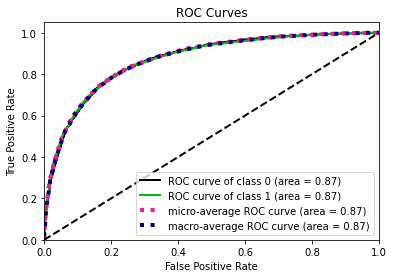

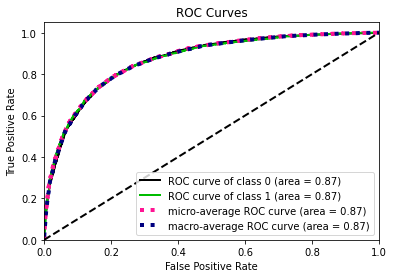

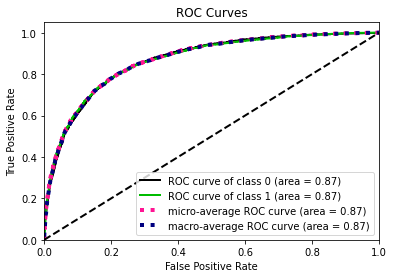

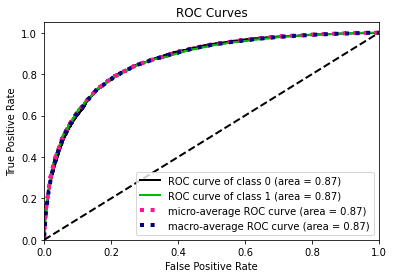

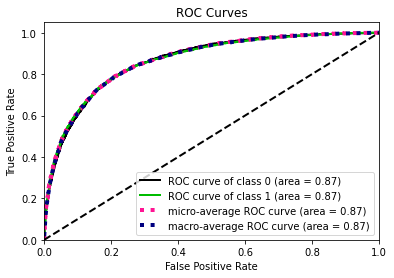

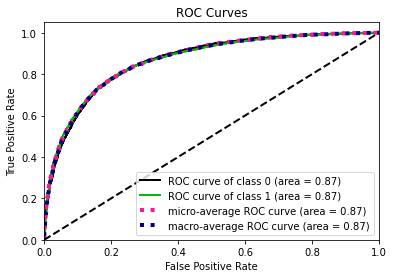

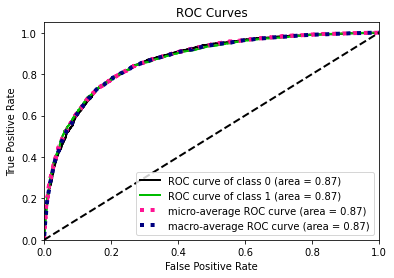

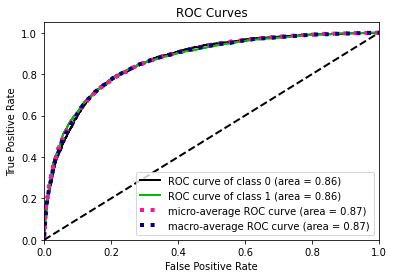

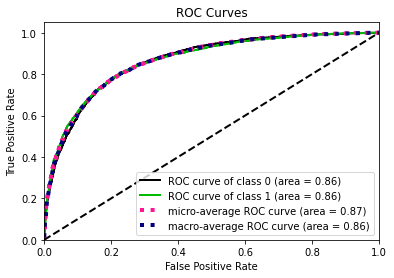

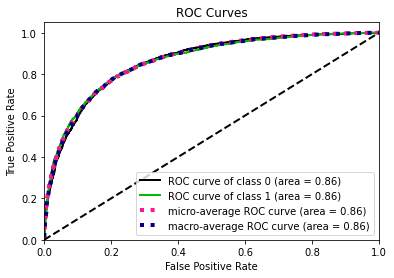

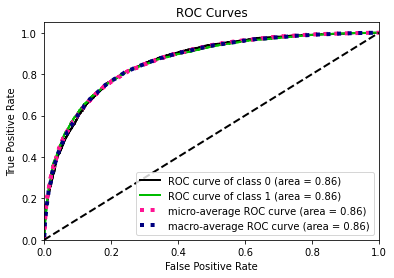

In [16]:
metrics_summary = []

for min_df in range(2,21):
    test_scores = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)
    
df_metrics_model1 = (pd
              .DataFrame(np.vstack(metrics_summary), 
                         columns=['min_df', 'test_precision_score','test_recall_score','test_f1_score'])
              .sort_values(['test_precision_score','test_f1_score'], ascending=[False, False])
             )

In [17]:
df_metrics_model1.head(20)

,min_df,test_precision_score,test_recall_score,test_f1_score
0,2.0,0.849815,0.817417,0.833302
1,3.0,0.849219,0.812558,0.830484
17,19.0,0.848016,0.778920,0.812001
16,18.0,0.847839,0.780976,0.813035
5,7.0,0.846290,0.801532,0.823304
14,16.0,0.846262,0.784900,0.814427
13,15.0,0.846185,0.785461,0.814693
12,14.0,0.846061,0.788825,0.816441
2,4.0,0.846048,0.806204,0.825646
15,17.0,0.845673,0.783405,0.813349


# Model 2


Metrics for Train Data:
Cross-validation score:  0.8274172059383327
Confusion matrix: 
 [[ 7361  1170]
 [ 2457 10028]]
precision:0.90
recall:  0.80 
f1 score: 0.85 
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      8531
           1       0.90      0.80      0.85     12485

    accuracy                           0.83     21016
   macro avg       0.82      0.83      0.82     21016
weighted avg       0.84      0.83      0.83     21016


Metrics for Test Data:
Cross-validation score:  0.7900754884547069
Confusion matrix: 
 [[2970  687]
 [1204 4147]]
precision:0.86
recall:  0.77 
f1 score: 0.81 
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      3657
           1       0.86      0.77      0.81      5351

    accuracy                           0.79      9008
   macro avg       0.78      0.79      0.79      9008
weighted avg       0.80      0.79      0.79      9008



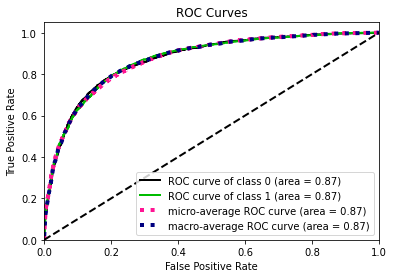

In [18]:
model_name='model_2'
vect = CountVectorizer(min_df =3)
lr = LogisticRegression(class_weight='balanced',max_iter=15, C=0.1)
pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', lr)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

In [19]:
vect = CountVectorizer(min_df =3)
lr = LogisticRegression(class_weight='balanced',max_iter=15)
pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', lr)])

#finding best parameters using GridSearchCV
param_grid = {"classifier__C": [0.001, 0.01, 0.1, 1, 10],
              "classifier__max_iter" : [10,15],
              #"vectorizer__max_df": [1, 3, 10],
              "vectorizer__ngram_range": [(1,1), (1,2), (1,3)]
             }

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring = 'precision')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

grid.best_estimator_

Best cross-validation score: 0.85


Pipeline(steps=[('vectorizer', CountVectorizer(min_df=3)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=15))])

# Model 3


Metrics for Train Data:
Cross-validation score:  0.870574800152265
Confusion matrix: 
 [[ 7552   979]
 [ 1741 10744]]
precision:0.92
recall:  0.86 
f1 score: 0.89 
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      8531
           1       0.92      0.86      0.89     12485

    accuracy                           0.87     21016
   macro avg       0.86      0.87      0.87     21016
weighted avg       0.87      0.87      0.87     21016


Metrics for Test Data:
Cross-validation score:  0.802619893428064
Confusion matrix: 
 [[2900  757]
 [1021 4330]]
precision:0.85
recall:  0.81 
f1 score: 0.83 
              precision    recall  f1-score   support

           0       0.74      0.79      0.77      3657
           1       0.85      0.81      0.83      5351

    accuracy                           0.80      9008
   macro avg       0.80      0.80      0.80      9008
weighted avg       0.81      0.80      0.80      9008



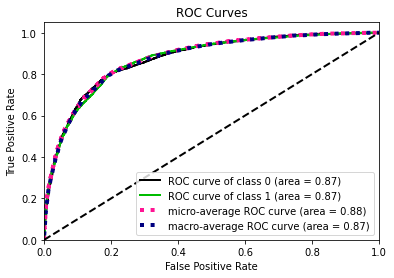

In [20]:
model_name='model_3'
#ngram parameter is added according to gridsearch results
vect = CountVectorizer(min_df =3, ngram_range=(1, 3))
lr = LogisticRegression(class_weight='balanced',max_iter=15, C=0.1)
pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', lr)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

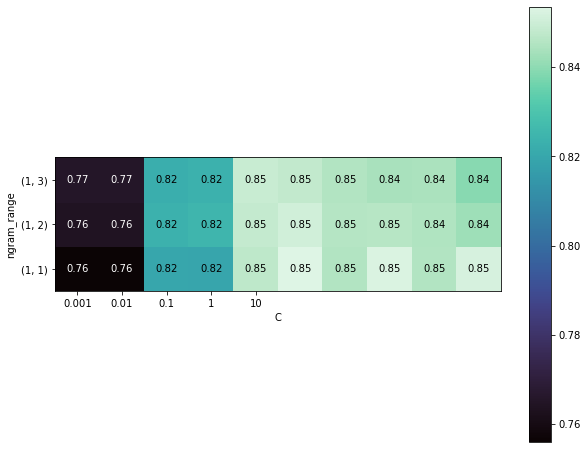

In [21]:
fig, ax = plt.subplots(figsize=(10,8))  
scores = grid.cv_results_['mean_test_score'].reshape(-1,3).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel = 'C', ylabel = 'ngram_range', cmap = 'mako',
    xticklabels = param_grid['classifier__C'],
    yticklabels = param_grid['vectorizer__ngram_range'] # "classifier__max_iter"
)
plt.colorbar(heatmap)

In [22]:
#max_df tries for different models
def train_and_eval_model(max_df):
    vect = CountVectorizer(max_df = max_df,min_df =3, ngram_range=(1, 3))
    lr = LogisticRegression(class_weight='balanced',max_iter=15, C=0.1)
    pipeline = Pipeline(steps=[('vectorizer', vect),
                                ('classifier', lr)])
    
    print(f'MAXIMUM DOCUMENT FREQUENCY = {max_df}')
    print('')
    
    model_name='model_4_tries'
    metrics_dict, pred_train, pred_test, preds_proba = run_model_metrics.run_pipeline(model_name, pipeline, 
                                                                                      X_train, y_train, 
                                                                                      X_test, y_test)
    
    
    test_precision_score = precision_score(y_test, pred_test)
    test_recall_score = recall_score(y_test, pred_test)
    test_f1_score = f1_score(y_test, pred_test)
    test_results = np.append(np.array([max_df, test_precision_score,test_recall_score]),
                                      test_f1_score
                                     )
    return test_results

MAXIMUM DOCUMENT FREQUENCY = 0.1


Metrics for Train Data:
Cross-validation score:  0.8859440426341835
Confusion matrix: 
 [[ 7685   846]
 [ 1551 10934]]
precision:0.93
recall:  0.88 
f1 score: 0.90 
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      8531
           1       0.93      0.88      0.90     12485

    accuracy                           0.89     21016
   macro avg       0.88      0.89      0.88     21016
weighted avg       0.89      0.89      0.89     21016


Metrics for Test Data:
Cross-validation score:  0.8038410301953819
Confusion matrix: 
 [[2899  758]
 [1009 4342]]
precision:0.85
recall:  0.81 
f1 score: 0.83 
              precision    recall  f1-score   support

           0       0.74      0.79      0.77      3657
           1       0.85      0.81      0.83      5351

    accuracy                           0.80      9008
   macro avg       0.80      0.80      0.80      9008
weighted avg       0.81      0.80      0

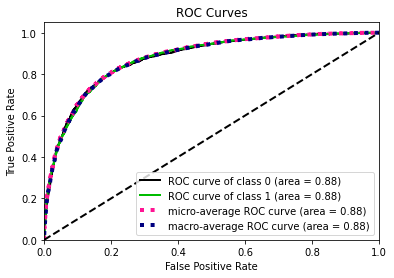

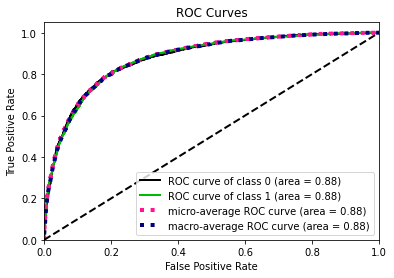

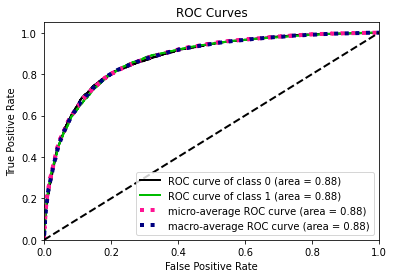

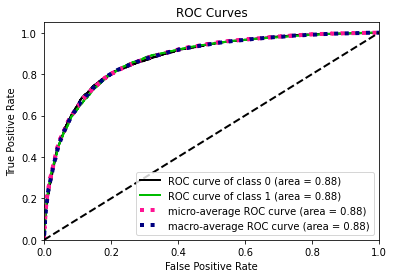

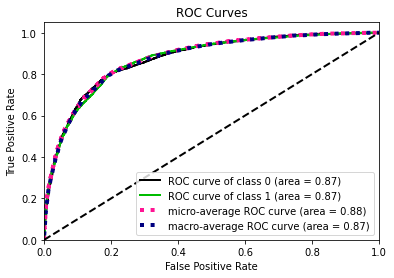

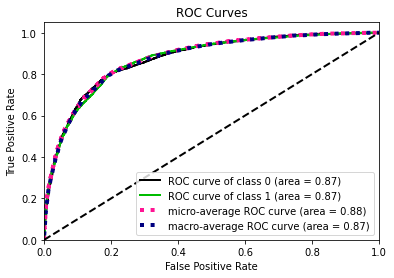

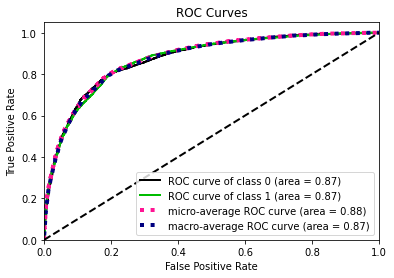

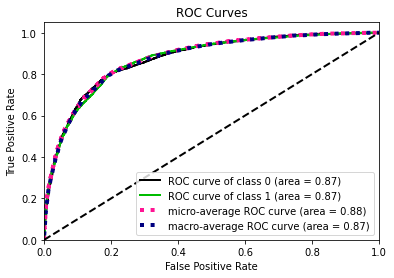

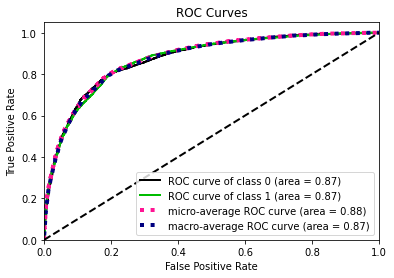

In [23]:
metrics_summary = []

for max_df in np.arange(0.1, 1.0, 0.1):
    test_scores = train_and_eval_model(max_df)
    metrics_summary.append(test_scores)
    
df_metrics_model4 = (pd
              .DataFrame(np.vstack(metrics_summary), 
                         columns=['max_df', 'test_precision_score','test_recall_score','test_f1_score'])
              .sort_values(['test_precision_score','test_f1_score'], ascending=[False, False])
             )

In [24]:
df_metrics_model4

,max_df,test_precision_score,test_recall_score,test_f1_score
2,0.3,0.856256,0.799290,0.826793
3,0.4,0.856256,0.799290,0.826793
1,0.2,0.852072,0.803027,0.826823
0,0.1,0.851373,0.811437,0.830925
4,0.5,0.851189,0.809195,0.829661
5,0.6,0.851189,0.809195,0.829661
6,0.7,0.851189,0.809195,0.829661
7,0.8,0.851189,0.809195,0.829661
8,0.9,0.851189,0.809195,0.829661


# Model 4


Metrics for Train Data:
Cross-validation score:  0.8859440426341835
Confusion matrix: 
 [[ 7685   846]
 [ 1551 10934]]
precision:0.93
recall:  0.88 
f1 score: 0.90 
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      8531
           1       0.93      0.88      0.90     12485

    accuracy                           0.89     21016
   macro avg       0.88      0.89      0.88     21016
weighted avg       0.89      0.89      0.89     21016


Metrics for Test Data:
Cross-validation score:  0.8038410301953819
Confusion matrix: 
 [[2899  758]
 [1009 4342]]
precision:0.85
recall:  0.81 
f1 score: 0.83 
              precision    recall  f1-score   support

           0       0.74      0.79      0.77      3657
           1       0.85      0.81      0.83      5351

    accuracy                           0.80      9008
   macro avg       0.80      0.80      0.80      9008
weighted avg       0.81      0.80      0.80      9008



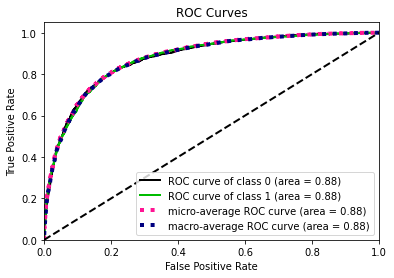

In [25]:
#max_df parameters is added
model_name = 'model_4'
vect = CountVectorizer(min_df =3, max_df=0.1, ngram_range=(1, 3))
lr = LogisticRegression(C=0.1, class_weight='balanced', max_iter=15)
pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', lr)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

In [26]:
df_metrics

,model,train_precision_score,train_recall_score,train_f1_score,test_precision_score,test_recall_score,test_f1_score
0,base_model,0.963407,0.934161,0.948558,0.851643,0.818539,0.834763
1,model_2,0.895517,0.803204,0.846852,0.857882,0.774995,0.814335
2,model_3,0.916489,0.860553,0.887640,0.851189,0.809195,0.829661
3,model_4,0.928183,0.875771,0.901216,0.851373,0.811437,0.830925


Model 4

# TFIDF

In [27]:
tvec = TfidfVectorizer()
#min_df=5, max_df = 0.55, stop_words = "english", ngram_range =(1,3), norm=None
lr = LogisticRegression(C=0.1, class_weight='balanced', max_iter=1)
                        
pipeline = Pipeline(steps=[('tfidfvectorizer', tvec),
                            ('logisticregression', lr)])
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
              "tfidfvectorizer__min_df": [1, 3, 10],
              "tfidfvectorizer__max_df": [1, 3, 10], 
              "tfidfvectorizer__ngram_range": [(1,1), (1,2), (1,3)], 
              "tfidfvectorizer__stop_words": [None, "english"]}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring = 'precision')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

grid.best_estimator_

Best cross-validation score: 0.82


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=10, ngram_range=(1, 3))),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1))])

In [28]:
grid.best_params_

{'logisticregression__C': 0.001,
 'tfidfvectorizer__max_df': 10,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 3),
 'tfidfvectorizer__stop_words': None}

In [29]:
#min_df tries for different models
def train_and_eval_model(min_df):
    tvec = TfidfVectorizer(min_df = min_df)
    lr = LogisticRegression(class_weight='balanced')
    pipeline = Pipeline(steps=[('vectorizer', tvec),
                                ('classifier', lr)])
    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    model_name='model_5_tries'
    metrics_dict, pred_train, pred_test, preds_proba = run_model_metrics.run_pipeline(model_name, pipeline, 
                                                                                      X_train, y_train, 
                                                                                      X_test, y_test)
    
    
    test_precision_score = precision_score(y_test, pred_test)
    test_recall_score = recall_score(y_test, pred_test)
    test_f1_score = f1_score(y_test, pred_test)
    test_results = np.append(np.array([min_df, test_precision_score,test_recall_score]),
                                      test_f1_score
                                     )
    return test_results

MINIMUM DOCUMENT FREQUENCY = 2


Metrics for Train Data:
Cross-validation score:  0.8748096688237533
Confusion matrix: 
 [[ 7569   962]
 [ 1669 10816]]
precision:0.92
recall:  0.87 
f1 score: 0.89 
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      8531
           1       0.92      0.87      0.89     12485

    accuracy                           0.87     21016
   macro avg       0.87      0.88      0.87     21016
weighted avg       0.88      0.87      0.88     21016


Metrics for Test Data:
Cross-validation score:  0.8112788632326821
Confusion matrix: 
 [[2945  712]
 [ 988 4363]]
precision:0.86
recall:  0.82 
f1 score: 0.84 
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      3657
           1       0.86      0.82      0.84      5351

    accuracy                           0.81      9008
   macro avg       0.80      0.81      0.81      9008
weighted avg       0.81      0.81      0.8


Metrics for Train Data:
Cross-validation score:  0.8437381043014845
Confusion matrix: 
 [[ 7279  1252]
 [ 2032 10453]]
precision:0.89
recall:  0.84 
f1 score: 0.86 
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      8531
           1       0.89      0.84      0.86     12485

    accuracy                           0.84     21016
   macro avg       0.84      0.85      0.84     21016
weighted avg       0.85      0.84      0.84     21016


Metrics for Test Data:
Cross-validation score:  0.7995115452930728
Confusion matrix: 
 [[2907  750]
 [1056 4295]]
precision:0.85
recall:  0.80 
f1 score: 0.83 
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      3657
           1       0.85      0.80      0.83      5351

    accuracy                           0.80      9008
   macro avg       0.79      0.80      0.79      9008
weighted avg       0.80      0.80      0.80      9008

MINIMUM DOCUMENT FR


Metrics for Train Data:
Cross-validation score:  0.8239912447658927
Confusion matrix: 
 [[ 7139  1392]
 [ 2307 10178]]
precision:0.88
recall:  0.82 
f1 score: 0.85 
              precision    recall  f1-score   support

           0       0.76      0.84      0.79      8531
           1       0.88      0.82      0.85     12485

    accuracy                           0.82     21016
   macro avg       0.82      0.83      0.82     21016
weighted avg       0.83      0.82      0.83     21016


Metrics for Test Data:
Cross-validation score:  0.7884103019538188
Confusion matrix: 
 [[2871  786]
 [1120 4231]]
precision:0.84
recall:  0.79 
f1 score: 0.82 
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      3657
           1       0.84      0.79      0.82      5351

    accuracy                           0.79      9008
   macro avg       0.78      0.79      0.78      9008
weighted avg       0.79      0.79      0.79      9008



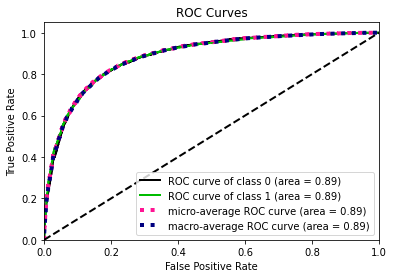

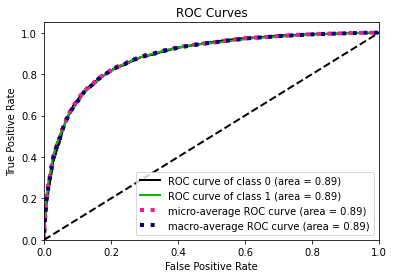

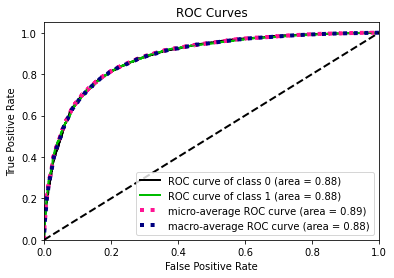

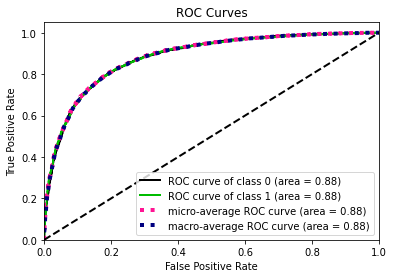

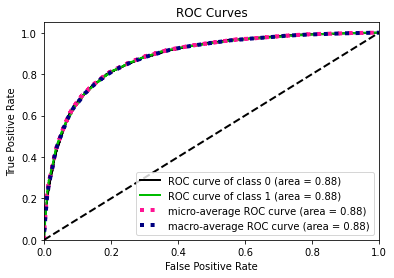

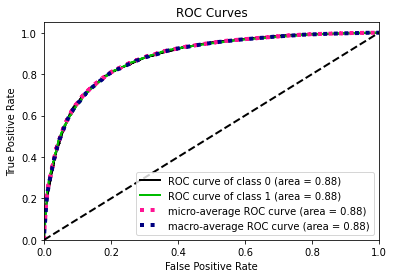

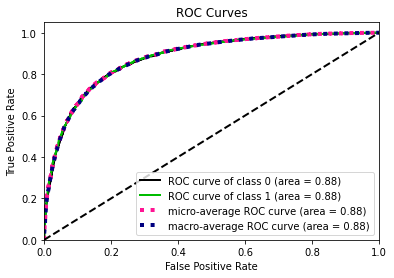

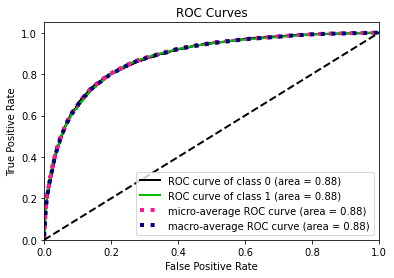

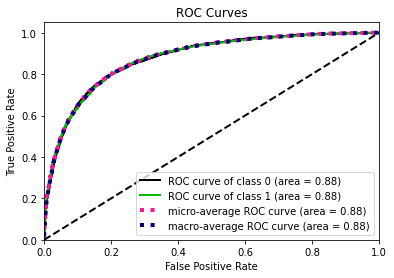

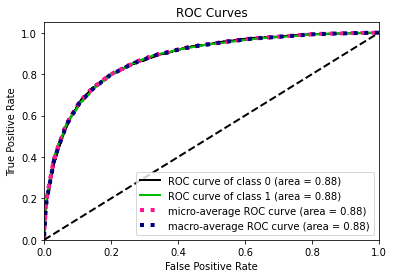

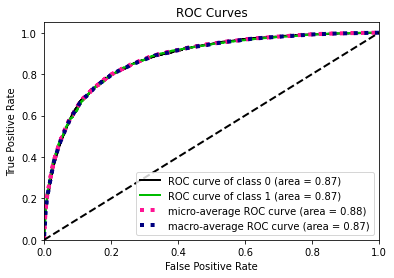

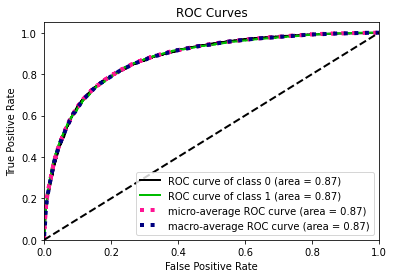

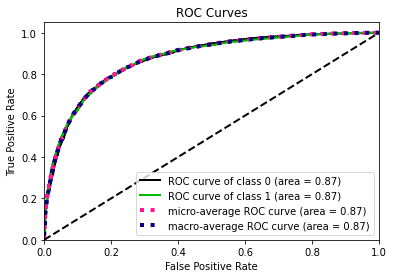

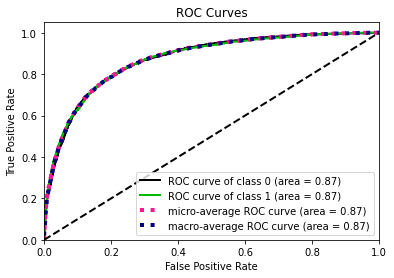

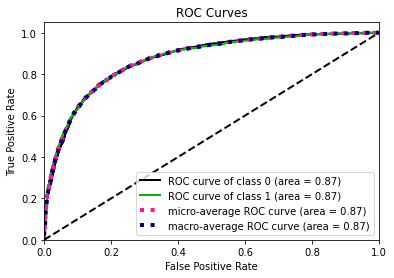

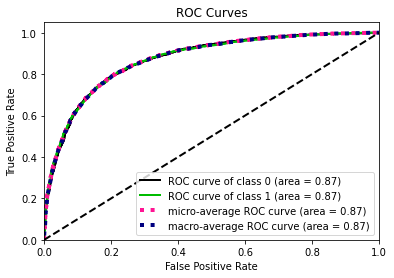

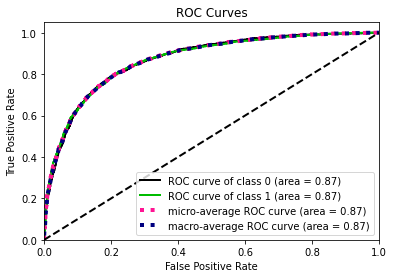

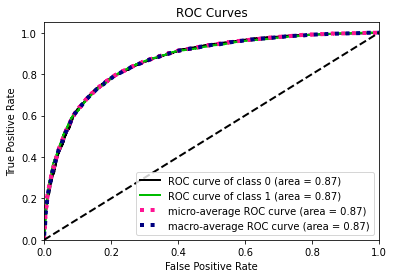

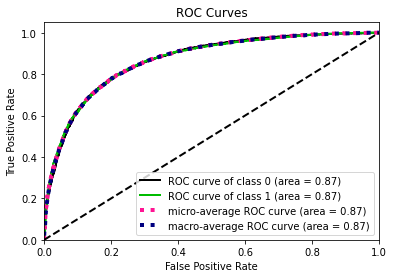

In [30]:
metrics_summary = []

for min_df in range(2,21):
    test_scores = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)
    
df_metrics_model5 = (pd
              .DataFrame(np.vstack(metrics_summary), 
                         columns=['min_df', 'test_precision_score','test_recall_score','test_f1_score'])
              .sort_values(['test_precision_score','test_f1_score'], ascending=[False, False])
             )

In [31]:
df_metrics_model5.head()

,min_df,test_precision_score,test_recall_score,test_f1_score
0,2.0,0.859704,0.815362,0.836946
1,3.0,0.858496,0.812932,0.835093
2,4.0,0.856073,0.811437,0.833157
4,6.0,0.855904,0.811437,0.833078
5,7.0,0.855193,0.807886,0.830867


# Model 5


Metrics for Train Data:
Cross-validation score:  0.9090216977540921
Confusion matrix: 
 [[ 7851   680]
 [ 1232 11253]]
precision:0.94
recall:  0.90 
f1 score: 0.92 
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      8531
           1       0.94      0.90      0.92     12485

    accuracy                           0.91     21016
   macro avg       0.90      0.91      0.91     21016
weighted avg       0.91      0.91      0.91     21016


Metrics for Test Data:
Cross-validation score:  0.8101687388987566
Confusion matrix: 
 [[2831  826]
 [ 884 4467]]
precision:0.84
recall:  0.83 
f1 score: 0.84 
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      3657
           1       0.84      0.83      0.84      5351

    accuracy                           0.81      9008
   macro avg       0.80      0.80      0.80      9008
weighted avg       0.81      0.81      0.81      9008



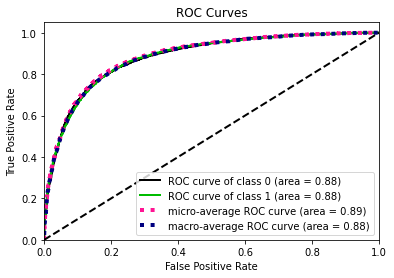

In [32]:
#According to df and gridsearch best combination of parameters are runned
model_name = 'model_5'
#according to grid search results Tfidf is applied
tvec = TfidfVectorizer(min_df=2, ngram_range=(1, 3))
lr = LogisticRegression(class_weight='balanced')
pipeline = Pipeline(steps=[('vectorizer', tvec),
                            ('classifier', lr)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

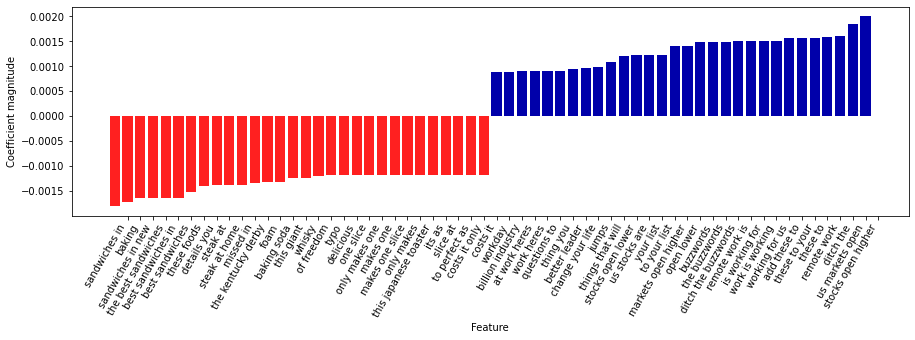

In [33]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=30)

In [34]:
tvec = TfidfVectorizer()
#min_df=5, max_df = 0.55, stop_words = "english", ngram_range =(1,3), norm=None
lr = LogisticRegression(class_weight='balanced')
smote =SMOTE(random_state=42)  

pipeline = Pipeline(steps=[('tfidfvectorizer', tvec),
                            ('logisticregression', lr)])
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
              "tfidfvectorizer__min_df": [1, 3, 10],
              "tfidfvectorizer__max_df": [1, 3, 10], 
              "tfidfvectorizer__ngram_range": [(1,1), (1,2), (1,3)]
             }

smt_pipeline = make_pipeline(tvec, smote, lr)

grid = GridSearchCV(smt_pipeline, param_grid, cv=5, scoring = 'precision')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

grid.best_estimator_

Best cross-validation score: 0.79


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=3, ngram_range=(1, 3))),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression',
                 LogisticRegression(C=10, class_weight='balanced'))])

In [35]:
#min_df tries for different models
def train_and_eval_model(min_df):
    tvec = TfidfVectorizer(min_df = min_df)
    lr = LogisticRegression(class_weight='balanced')
    smote =SMOTE(random_state=42)

    smt_pipeline = make_pipeline(tvec, smote, lr)

    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    model_name='model_6_tries'
    metrics_dict, pred_train, pred_test, preds_proba = run_model_metrics.run_pipeline(model_name, smt_pipeline, 
                                                                                      X_train, y_train, 
                                                                                      X_test, y_test)
    
    
    test_precision_score = precision_score(y_test, pred_test)
    test_recall_score = recall_score(y_test, pred_test)
    test_f1_score = f1_score(y_test, pred_test)
    test_results = np.append(np.array([min_df, test_precision_score,test_recall_score]),
                                      test_f1_score
                                     )
    return test_results

MINIMUM DOCUMENT FREQUENCY = 2


Metrics for Train Data:
Cross-validation score:  0.8783783783783784
Confusion matrix: 
 [[ 7493  1038]
 [ 1518 10967]]
precision:0.91
recall:  0.88 
f1 score: 0.90 
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      8531
           1       0.91      0.88      0.90     12485

    accuracy                           0.88     21016
   macro avg       0.87      0.88      0.87     21016
weighted avg       0.88      0.88      0.88     21016


Metrics for Test Data:
Cross-validation score:  0.8140541740674956
Confusion matrix: 
 [[2891  766]
 [ 909 4442]]
precision:0.85
recall:  0.83 
f1 score: 0.84 
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      3657
           1       0.85      0.83      0.84      5351

    accuracy                           0.81      9008
   macro avg       0.81      0.81      0.81      9008
weighted avg       0.82      0.81      0.8


Metrics for Train Data:
Cross-validation score:  0.845688998858013
Confusion matrix: 
 [[ 7211  1320]
 [ 1923 10562]]
precision:0.89
recall:  0.85 
f1 score: 0.87 
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      8531
           1       0.89      0.85      0.87     12485

    accuracy                           0.85     21016
   macro avg       0.84      0.85      0.84     21016
weighted avg       0.85      0.85      0.85     21016


Metrics for Test Data:
Cross-validation score:  0.7962921847246892
Confusion matrix: 
 [[2862  795]
 [1040 4311]]
precision:0.84
recall:  0.81 
f1 score: 0.82 
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      3657
           1       0.84      0.81      0.82      5351

    accuracy                           0.80      9008
   macro avg       0.79      0.79      0.79      9008
weighted avg       0.80      0.80      0.80      9008

MINIMUM DOCUMENT FRE


Metrics for Train Data:
Cross-validation score:  0.8256090597639894
Confusion matrix: 
 [[ 7047  1484]
 [ 2181 10304]]
precision:0.87
recall:  0.83 
f1 score: 0.85 
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      8531
           1       0.87      0.83      0.85     12485

    accuracy                           0.83     21016
   macro avg       0.82      0.83      0.82     21016
weighted avg       0.83      0.83      0.83     21016


Metrics for Test Data:
Cross-validation score:  0.7900754884547069
Confusion matrix: 
 [[2839  818]
 [1073 4278]]
precision:0.84
recall:  0.80 
f1 score: 0.82 
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      3657
           1       0.84      0.80      0.82      5351

    accuracy                           0.79      9008
   macro avg       0.78      0.79      0.78      9008
weighted avg       0.79      0.79      0.79      9008



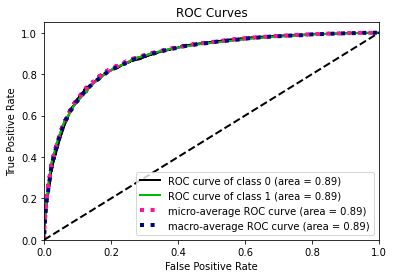

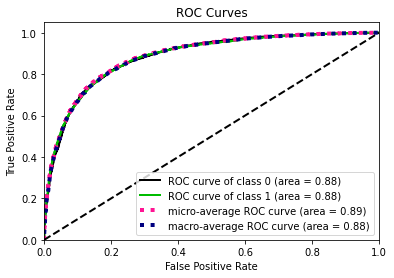

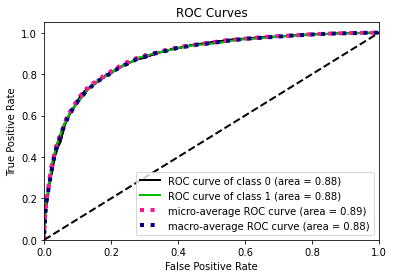

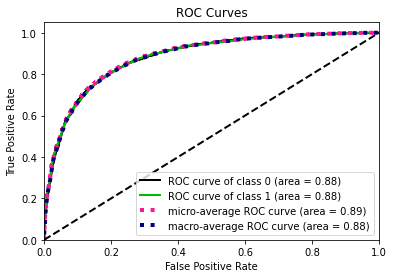

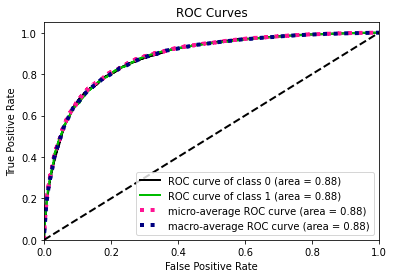

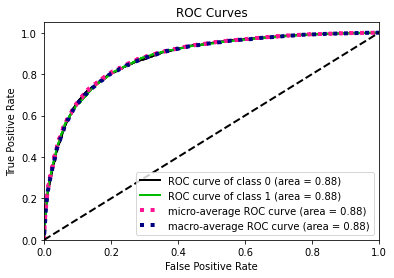

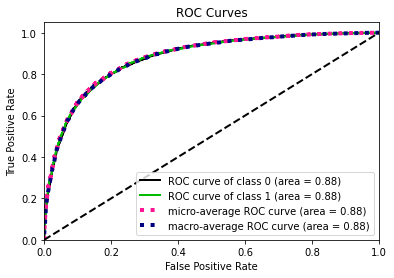

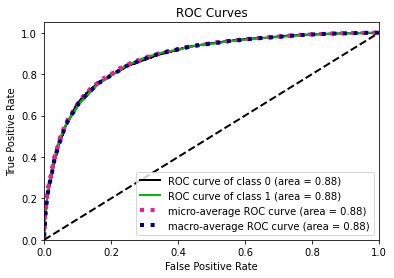

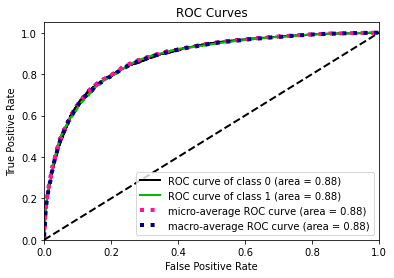

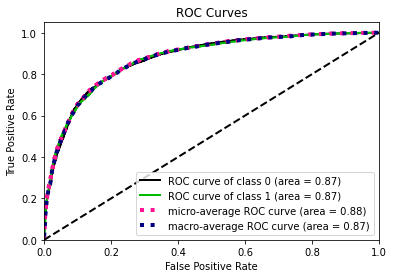

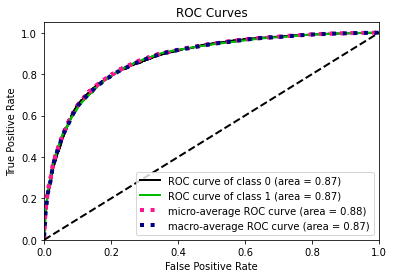

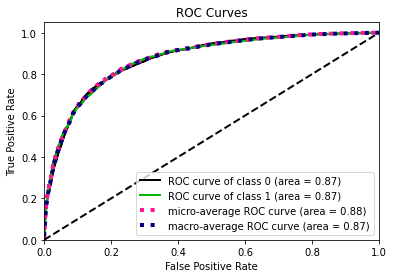

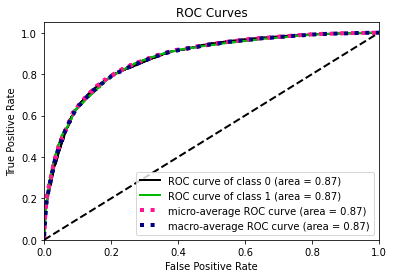

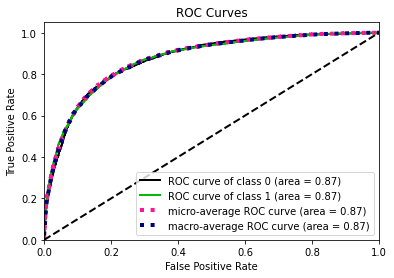

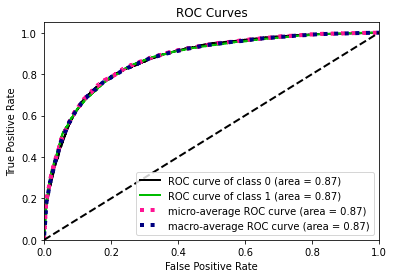

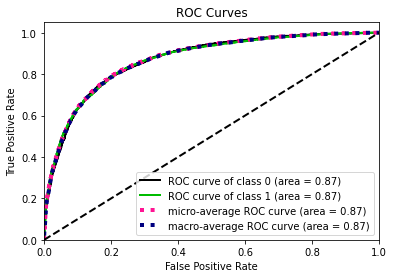

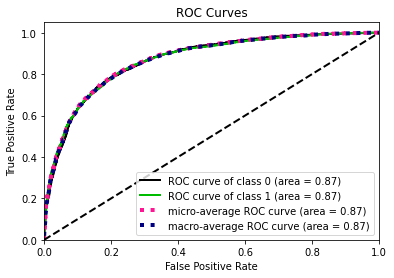

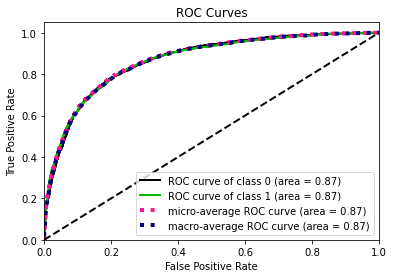

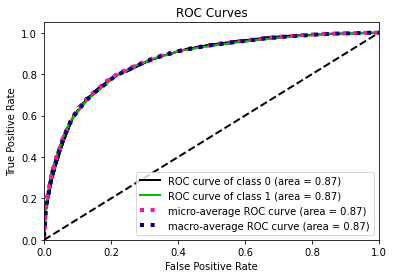

In [36]:
metrics_summary = []

for min_df in range(2,21):
    test_scores = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)
    
df_metrics_model6 = (pd
              .DataFrame(np.vstack(metrics_summary), 
                         columns=['min_df', 'test_precision_score','test_recall_score','test_f1_score'])
              .sort_values(['test_precision_score','test_f1_score'], ascending=[False, False])
             )

In [37]:
df_metrics_model6

,min_df,test_precision_score,test_recall_score,test_f1_score
0,2.0,0.852919,0.830125,0.841368
1,3.0,0.849460,0.823584,0.836322
4,6.0,0.848567,0.818912,0.833476
5,7.0,0.848126,0.816109,0.831810
2,4.0,0.848023,0.821716,0.834662
3,5.0,0.847131,0.822276,0.834519
6,8.0,0.846961,0.814988,0.830667
10,12.0,0.846607,0.806578,0.826108
15,17.0,0.845503,0.802841,0.823620
9,11.0,0.844301,0.805644,0.824519


In [40]:
df_metrics_model5.head()

,min_df,test_precision_score,test_recall_score,test_f1_score
0,2.0,0.859704,0.815362,0.836946
1,3.0,0.858496,0.812932,0.835093
2,4.0,0.856073,0.811437,0.833157
4,6.0,0.855904,0.811437,0.833078
5,7.0,0.855193,0.807886,0.830867


TFIDF

In [41]:
tvec = TfidfVectorizer(min_df=2)
#min_df=5, max_df = 0.55, stop_words = "english", ngram_range =(1,3), norm=None
lr = LogisticRegression(class_weight='balanced')
smote =SMOTE(random_state=42)  

pipeline = Pipeline(steps=[('tfidfvectorizer', tvec),
                            ('logisticregression', lr)])
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
              #"tfidfvectorizer__min_df": [1, 3, 10],
              #"tfidfvectorizer__max_df": [1, 3, 10], 
              "tfidfvectorizer__ngram_range": [(1,1), (1,2), (1,3)]
             }

smt_pipeline = make_pipeline(tvec, smote, lr)

grid = GridSearchCV(smt_pipeline, param_grid, cv=5, scoring = 'precision')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

grid.best_estimator_

Best cross-validation score: 0.85


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(min_df=2)),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight='balanced'))])

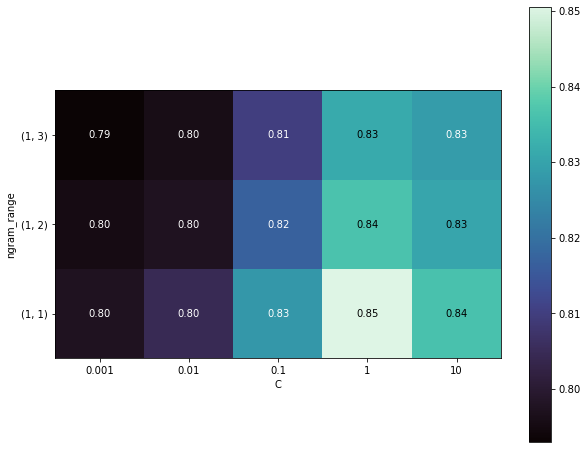

In [42]:
fig, ax = plt.subplots(figsize=(10,8))  
scores = grid.cv_results_['mean_test_score'].reshape(-1,3).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel = 'C', ylabel = 'ngram_range', cmap = 'mako',
    xticklabels = param_grid['logisticregression__C'],
    yticklabels = param_grid['tfidfvectorizer__ngram_range'] # "classifier__max_iter"
)
plt.colorbar(heatmap)

SMOTE
###### Model 6


Metrics for Train Data:
Cross-validation score:  0.8783783783783784
Confusion matrix: 
 [[ 7493  1038]
 [ 1518 10967]]
precision:0.91
recall:  0.88 
f1 score: 0.90 
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      8531
           1       0.91      0.88      0.90     12485

    accuracy                           0.88     21016
   macro avg       0.87      0.88      0.87     21016
weighted avg       0.88      0.88      0.88     21016


Metrics for Test Data:
Cross-validation score:  0.8140541740674956
Confusion matrix: 
 [[2891  766]
 [ 909 4442]]
precision:0.85
recall:  0.83 
f1 score: 0.84 
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      3657
           1       0.85      0.83      0.84      5351

    accuracy                           0.81      9008
   macro avg       0.81      0.81      0.81      9008
weighted avg       0.82      0.81      0.81      9008


Metrics for Train 

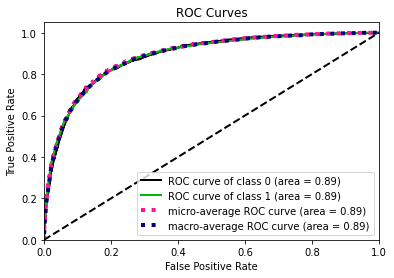

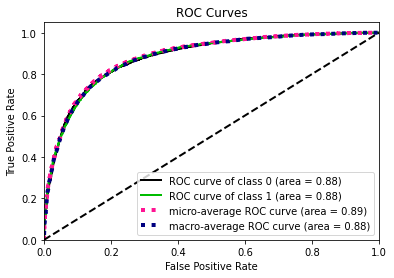

In [ ]:
#According to df and gridsearch best combination of parameters are runned
model_name = 'model_5'
#according to grid search#making pipeline using best parameters of tfidf and model
model_name = 'model_6'
tvec = TfidfVectorizer(min_df=2, ngram_range=(1, 1))
lr = LogisticRegression(C=1, class_weight='balanced')
smote =SMOTE(random_state=42)

smt_pipeline = make_pipeline(tvec, smote, lr)

metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, smt_pipeline, X_train, y_train, X_test, y_test)
#df_metrics=df_metrics.append([metrics_dict], ignore_index=True) results Tfidf is applied
tvec = TfidfVectorizer(min_df=2, ngram_range=(1, 3))
lr = LogisticRegression(class_weight='balanced')
pipeline = Pipeline(steps=[('vectorizer', tvec),
                            ('classifier', lr)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)


Metrics for Train Data:
Cross-validation score:  0.8778073848496384
Confusion matrix: 
 [[ 7539   992]
 [ 1576 10909]]
precision:0.92
recall:  0.87 
f1 score: 0.89 
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      8531
           1       0.92      0.87      0.89     12485

    accuracy                           0.88     21016
   macro avg       0.87      0.88      0.87     21016
weighted avg       0.88      0.88      0.88     21016


Metrics for Test Data:
Cross-validation score:  0.8122779751332149
Confusion matrix: 
 [[2896  761]
 [ 930 4421]]
precision:0.85
recall:  0.83 
f1 score: 0.84 
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      3657
           1       0.85      0.83      0.84      5351

    accuracy                           0.81      9008
   macro avg       0.81      0.81      0.81      9008
weighted avg       0.81      0.81      0.81      9008



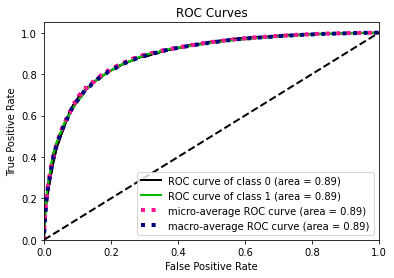

In [ ]:
model_name = 'model_7'
#making pipeline using best parameters of tfidf and model
tvec = TfidfVectorizer(min_df=2, ngram_range=(1, 1))
lr = LogisticRegression(C=1, class_weight='balanced')
ros = RandomOverSampler(random_state=0)

smt_pipeline = make_pipeline(tvec, ros, lr)

metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, smt_pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

In [ ]:
df_metrics

,model,train_precision_score,train_recall_score,train_f1_score,test_precision_score,test_recall_score,test_f1_score
0,base_model,0.963407,0.934161,0.948558,0.851643,0.818539,0.834763
1,model_2,0.895517,0.803204,0.846852,0.857882,0.774995,0.814335
2,model_3,0.916489,0.860553,0.887640,0.851189,0.809195,0.829661
3,model_4,0.928183,0.875771,0.901216,0.851373,0.811437,0.830925
4,model_5,0.943015,0.901322,0.921697,0.843945,0.834797,0.839346
5,model_7,0.916646,0.873769,0.894694,0.853146,0.826201,0.839457
6,model_9,0.941139,0.954105,0.947578,0.816709,0.838535,0.827478
7,model_7,0.916646,0.873769,0.894694,0.853146,0.826201,0.839457


In [ ]:
tvec = TfidfVectorizer()
#min_df=5, max_df = 0.55, stop_words = "english", ngram_range =(1,3), norm=None
clf = MultinomialNB()
smote =SMOTE(random_state=42)  
vect = CountVectorizer()



param_grid = {#"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
              "vectorizer__min_df": [2, 3, 4],
              #"tfidfvectorizer__max_df": [1, 3, 10], 
              "vectorizer__ngram_range": [(1,1), (1,2), (1,3)]
             }

smt_pipeline = make_pipeline(tvec, smote, lr)
pipeline = Pipeline(steps=[('vectorizer', tvec),
                            ('classifier', clf)])
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring = 'precision')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

grid.best_estimator_

Best cross-validation score: 0.77


Pipeline(steps=[('vectorizer', TfidfVectorizer(min_df=4)),
                ('classifier', MultinomialNB())])

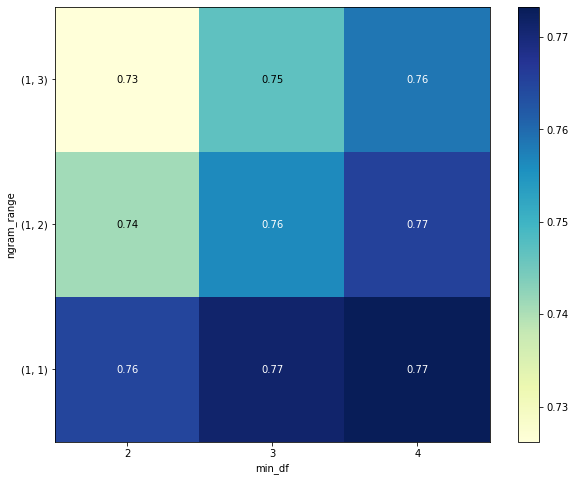

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))  
scores = grid.cv_results_['mean_test_score'].reshape(-1,3).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel = 'min_df', ylabel = 'ngram_range', cmap = 'YlGnBu',
    xticklabels = param_grid['vectorizer__min_df'],
    yticklabels = param_grid['vectorizer__ngram_range'] # "classifier__max_iter"
)
plt.colorbar(heatmap)

# Model 8


Metrics for Train Data:
Cross-validation score:  0.8557765511990864
Confusion matrix: 
 [[ 6761  1770]
 [ 1261 11224]]
precision:0.86
recall:  0.90 
f1 score: 0.88 
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      8531
           1       0.86      0.90      0.88     12485

    accuracy                           0.86     21016
   macro avg       0.85      0.85      0.85     21016
weighted avg       0.86      0.86      0.85     21016


Metrics for Test Data:
Cross-validation score:  0.8109458259325044
Confusion matrix: 
 [[2601 1056]
 [ 647 4704]]
precision:0.82
recall:  0.88 
f1 score: 0.85 
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      3657
           1       0.82      0.88      0.85      5351

    accuracy                           0.81      9008
   macro avg       0.81      0.80      0.80      9008
weighted avg       0.81      0.81      0.81      9008



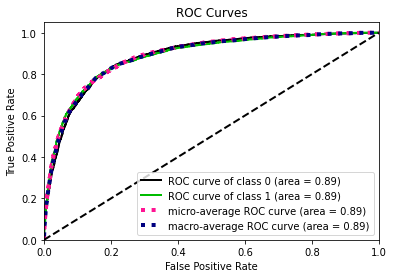

In [ ]:
model_name = 'model_8'
# train a classifier
tvec = TfidfVectorizer(min_df =3, max_df=0.1, ngram_range=(1, 2))
vect = CountVectorizer(min_df =3, ngram_range=(1, 1))

clf = MultinomialNB()
pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', clf)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

# Model 9


Metrics for Train Data:
Cross-validation score:  0.9372858774267225
Confusion matrix: 
 [[ 7786   745]
 [  573 11912]]
precision:0.94
recall:  0.95 
f1 score: 0.95 
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      8531
           1       0.94      0.95      0.95     12485

    accuracy                           0.94     21016
   macro avg       0.94      0.93      0.93     21016
weighted avg       0.94      0.94      0.94     21016


Metrics for Test Data:
Cross-validation score:  0.7922957371225577
Confusion matrix: 
 [[2650 1007]
 [ 864 4487]]
precision:0.82
recall:  0.84 
f1 score: 0.83 
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      3657
           1       0.82      0.84      0.83      5351

    accuracy                           0.79      9008
   macro avg       0.79      0.78      0.78      9008
weighted avg       0.79      0.79      0.79      9008



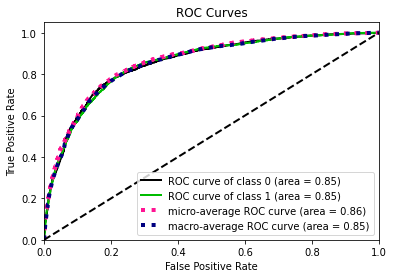

In [ ]:
model_name = 'model_9'
svc = SVC(kernel='linear', probability=True)

tvec = TfidfVectorizer(max_df=10, ngram_range=(1, 2))
vect = CountVectorizer(min_df =3)

pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', svc)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

In [ ]:
tvec = TfidfVectorizer()
#min_df=5, max_df = 0.55, stop_words = "english", ngram_range =(1,3), norm=None
clf = MultinomialNB()
smote =SMOTE(random_state=42)  
vect = CountVectorizer()

param_grid = {#"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
              "vectorizer__min_df": [2, 3, 4],
              #"tfidfvectorizer__max_df": [1, 3, 10], 
              "vectorizer__ngram_range": [(1,1), (1,2), (1,3)]
             }

smt_pipeline = make_pipeline(tvec, smote, lr)
pipeline = Pipeline(steps=[('vectorizer', tvec),
                            ('classifier', clf)])
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring = 'precision')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

grid.best_estimator_

In [ ]:
#finding best parameters using GridSearchCV
vect = CountVectorizer()
tvec = TfidfVectorizer()
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {#"vectorizer__C": [ 0.01, 0.1, 1],
              "vectorizer__max_df": [1, 3, 10],
              "vectorizer__ngram_range": [(1,1), (1,2), (1,3)],
              "classifier__n_estimators": [200, 400],
               "classifier__max_depth":  [10, 20, 30],
              "classifier__max_features": ['auto', 'sqrt']
             }

pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', rf)]
                   )

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring = 'precision')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

grid.best_estimator_

Best cross-validation score: 0.67


Pipeline(steps=[('vectorizer', CountVectorizer(max_df=10, ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        n_estimators=200, random_state=42))])

# Model 10

In [2]:
model_name = 'model_10'
#tvec = TfidfVectorizer(min_df=4, max_df=0.3, ngram_range=(1, 1))
vect = CountVectorizer(min_df=3, ngram_range=(1, 2))
rf = RandomForestClassifier(random_state=42, n_estimators=75, min_samples_leaf=3)

pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier',rf)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

NameError: ignored

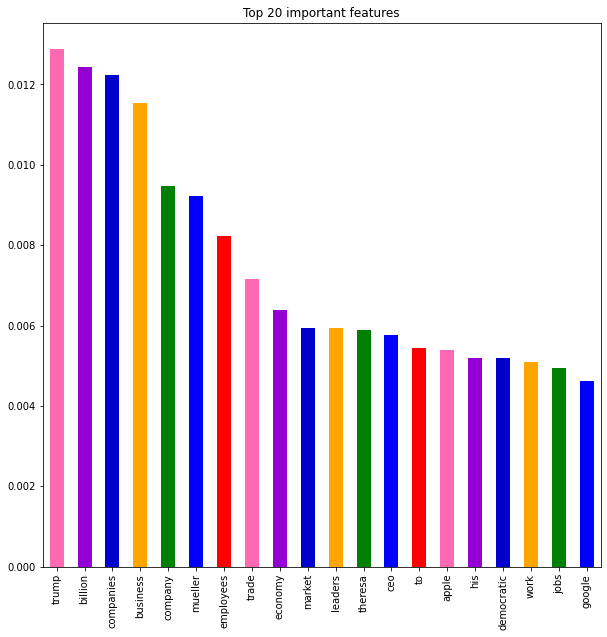

In [ ]:
plot_colors = ['hotpink','darkviolet','mediumblue', 'orange', 'green', 'blue', 'red']
feat_importances = pd.Series(rf.feature_importances_, index=vect.get_feature_names())
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10), color=plot_colors)
plt.title("Top 20 important features")
plt.show()

In [ ]:
df_metrics

,model,train_precision_score,train_recall_score,train_f1_score,test_precision_score,test_recall_score,test_f1_score
0,base_model,0.963407,0.934161,0.948558,0.851643,0.818539,0.834763
1,model_2,0.895517,0.803204,0.846852,0.857882,0.774995,0.814335
2,model_3,0.916489,0.860553,0.887640,0.851189,0.809195,0.829661
3,model_4,0.928183,0.875771,0.901216,0.851373,0.811437,0.830925
4,model_5,0.943015,0.901322,0.921697,0.843945,0.834797,0.839346
5,model_7,0.916646,0.873769,0.894694,0.853146,0.826201,0.839457
6,model_9,0.941139,0.954105,0.947578,0.816709,0.838535,0.827478
7,model_7,0.916646,0.873769,0.894694,0.853146,0.826201,0.839457
8,model_8,0.863783,0.898999,0.881039,0.816667,0.879088,0.846728
9,model_9,0.941139,0.954105,0.947578,0.816709,0.838535,0.827478


# Model 11


Metrics for Train Data:
Cross-validation score:  0.8274172059383327
Confusion matrix: 
 [[ 7361  1170]
 [ 2457 10028]]
precision:0.90
recall:  0.80 
f1 score: 0.85 
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      8531
           1       0.90      0.80      0.85     12485

    accuracy                           0.83     21016
   macro avg       0.82      0.83      0.82     21016
weighted avg       0.84      0.83      0.83     21016


Metrics for Test Data:
Cross-validation score:  0.7900754884547069
Confusion matrix: 
 [[2970  687]
 [1204 4147]]
precision:0.86
recall:  0.77 
f1 score: 0.81 
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      3657
           1       0.86      0.77      0.81      5351

    accuracy                           0.79      9008
   macro avg       0.78      0.79      0.79      9008
weighted avg       0.80      0.79      0.79      9008



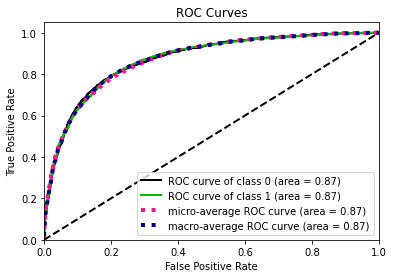

In [ ]:
model_name = 'model_11'
tvec = TfidfVectorizer(max_df=10, ngram_range=(1, 2))
vect = CountVectorizer(min_df =3)
lr=LogisticRegression(C=0.1, class_weight='balanced', max_iter=15)

rf = RandomForestClassifier()
pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', lr)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

In [ ]:
df_metrics

,model,train_precision_score,train_recall_score,train_f1_score,test_precision_score,test_recall_score,test_f1_score
0,base_model,0.963407,0.934161,0.948558,0.851643,0.818539,0.834763
1,model_2,0.895517,0.803204,0.846852,0.857882,0.774995,0.814335
2,model_3,0.916489,0.860553,0.887640,0.851189,0.809195,0.829661
3,model_4,0.928183,0.875771,0.901216,0.851373,0.811437,0.830925
4,model_5,0.943015,0.901322,0.921697,0.843945,0.834797,0.839346
5,model_7,0.916646,0.873769,0.894694,0.853146,0.826201,0.839457
6,model_9,0.941139,0.954105,0.947578,0.816709,0.838535,0.827478
7,model_7,0.916646,0.873769,0.894694,0.853146,0.826201,0.839457
8,model_8,0.863783,0.898999,0.881039,0.816667,0.879088,0.846728
9,model_9,0.941139,0.954105,0.947578,0.816709,0.838535,0.827478



Metrics for Train Data:
Cross-validation score:  0.8099543205177008
Confusion matrix: 
 [[7025 1506]
 [2488 9997]]
precision:0.87
recall:  0.80 
f1 score: 0.83 
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      8531
           1       0.87      0.80      0.83     12485

    accuracy                           0.81     21016
   macro avg       0.80      0.81      0.81     21016
weighted avg       0.82      0.81      0.81     21016


Metrics for Test Data:
Cross-validation score:  0.783303730017762
Confusion matrix: 
 [[2858  799]
 [1153 4198]]
precision:0.84
recall:  0.78 
f1 score: 0.81 
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      3657
           1       0.84      0.78      0.81      5351

    accuracy                           0.78      9008
   macro avg       0.78      0.78      0.78      9008
weighted avg       0.79      0.78      0.78      9008



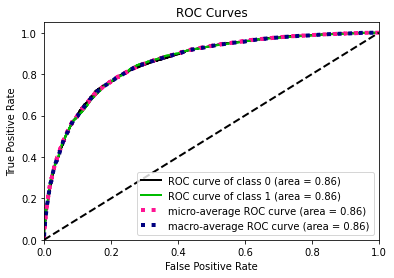

In [ ]:
model_name = 'model_12'
tvec = TfidfVectorizer(min_df =3, max_df=0.1, ngram_range=(1, 1))
vect = CountVectorizer(min_df =3)
lr=LogisticRegression(C=0.1, class_weight='balanced', max_iter=15)

rf = RandomForestClassifier(random_state=42, n_estimators=50)
pipeline = Pipeline(steps=[('vectorizer', tvec),
                            ('classifier', lr)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

In [ ]:
df_metrics

,model,train_precision_score,train_recall_score,train_f1_score,test_precision_score,test_recall_score,test_f1_score
0,base_model,0.963407,0.934161,0.948558,0.851643,0.818539,0.834763
1,model_2,0.895517,0.803204,0.846852,0.857882,0.774995,0.814335
2,model_3,0.916489,0.860553,0.887640,0.851189,0.809195,0.829661
3,model_4,0.928183,0.875771,0.901216,0.851373,0.811437,0.830925
4,model_5,0.943015,0.901322,0.921697,0.843945,0.834797,0.839346
5,model_7,0.916646,0.873769,0.894694,0.853146,0.826201,0.839457
6,model_9,0.941139,0.954105,0.947578,0.816709,0.838535,0.827478
7,model_7,0.916646,0.873769,0.894694,0.853146,0.826201,0.839457
8,model_8,0.863783,0.898999,0.881039,0.816667,0.879088,0.846728
9,model_9,0.941139,0.954105,0.947578,0.816709,0.838535,0.827478


Model 12


Metrics for Train Data:
Cross-validation score:  0.6736771983250857
Confusion matrix: 
 [[ 2116  6415]
 [  443 12042]]
precision:0.65
recall:  0.96 
f1 score: 0.78 
              precision    recall  f1-score   support

           0       0.83      0.25      0.38      8531
           1       0.65      0.96      0.78     12485

    accuracy                           0.67     21016
   macro avg       0.74      0.61      0.58     21016
weighted avg       0.72      0.67      0.62     21016


Metrics for Test Data:
Cross-validation score:  0.6724023090586145
Confusion matrix: 
 [[ 882 2775]
 [ 176 5175]]
precision:0.65
recall:  0.97 
f1 score: 0.78 
              precision    recall  f1-score   support

           0       0.83      0.24      0.37      3657
           1       0.65      0.97      0.78      5351

    accuracy                           0.67      9008
   macro avg       0.74      0.60      0.58      9008
weighted avg       0.73      0.67      0.61      9008



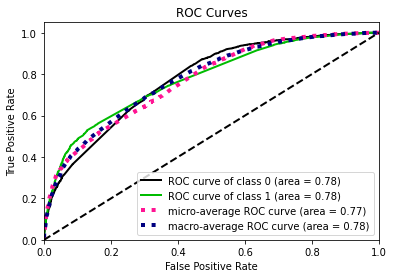

In [ ]:
model_name = 'model_13'
tvec = TfidfVectorizer(max_df=10, ngram_range=(1, 2))
vect = CountVectorizer(min_df =3)
xgb = XGBClassifier()

pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', xgb)])

metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
#df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

In [ ]:
model 13


Metrics for Train Data:
Cross-validation score:  0.9943852303007232
Confusion matrix: 
 [[ 8465    66]
 [   52 12433]]
precision:0.99
recall:  1.00 
f1 score: 1.00 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8531
           1       0.99      1.00      1.00     12485

    accuracy                           0.99     21016
   macro avg       0.99      0.99      0.99     21016
weighted avg       0.99      0.99      0.99     21016


Metrics for Test Data:
Cross-validation score:  0.7773090586145648
Confusion matrix: 
 [[2402 1255]
 [ 751 4600]]
precision:0.79
recall:  0.86 
f1 score: 0.82 
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      3657
           1       0.79      0.86      0.82      5351

    accuracy                           0.78      9008
   macro avg       0.77      0.76      0.76      9008
weighted avg       0.78      0.78      0.77      9008



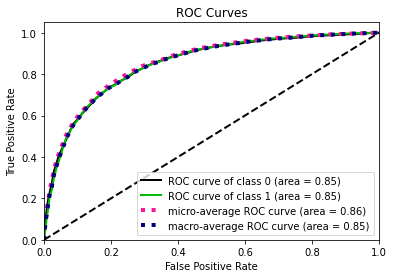

In [ ]:
model_name = 'model_14'

vect = CountVectorizer(min_df =3)
rf = RandomForestClassifier(n_estimators=50)

pipeline = Pipeline(steps=[('vectorizer', vect),
                            ('classifier', rf)])
metrics_dict, pred_train, pred_test, preds_proba =  run_model_metrics.run_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test)
#df_metrics=df_metrics.append([metrics_dict], ignore_index=True)

In [ ]:
df_metrics

,model,train_precision_score,train_recall_score,train_f1_score,test_precision_score,test_recall_score,test_f1_score
0,base_model,0.963407,0.934161,0.948558,0.851643,0.818539,0.834763
1,model_2,0.895517,0.803204,0.846852,0.857882,0.774995,0.814335
2,model_3,0.916489,0.860553,0.887640,0.851189,0.809195,0.829661
3,model_4,0.928183,0.875771,0.901216,0.851373,0.811437,0.830925
4,model_5,0.943015,0.901322,0.921697,0.843945,0.834797,0.839346
5,model_7,0.916646,0.873769,0.894694,0.853146,0.826201,0.839457
6,model_9,0.941139,0.954105,0.947578,0.816709,0.838535,0.827478
7,model_7,0.916646,0.873769,0.894694,0.853146,0.826201,0.839457
8,model_8,0.863783,0.898999,0.881039,0.816667,0.879088,0.846728
9,model_9,0.941139,0.954105,0.947578,0.816709,0.838535,0.827478
